# 2. Modelos de IA

Para o Sent.AI, três modelos de deep learning serão criados, treinados e avaliados - um para classificar se o texto exibe uma recomendação acionável, um para predizer o sentimento geral do texto e outro para identificar a emoção predominante no texto.

**Estrutura**

* Modelo de Recomendação
    * Carregamento dos Dados Preprocessados
    * Desenvolvimento da Arquitetura
    * Train Test Split
    * Treinamento do Modelo
    * Avaliação do Modelo

* Modelo de Emoção Predominante
    * Carregamento dos Dados Preprocessados
    * Desenvolvimento da Arquitetura
    * Train Test Split
    * Treinamento do Modelo
    * Avaliação do Modelo
    
* Modelo de Sentimento Geral
    * Carregamento dos Dados Preprocessados
    * Desenvolvimento da Arquitetura
    * Train Test Split
    * Treinamento do Modelo
    * Avaliação do Modelo

## Configurações iniciais

In [1]:
# Importações de libraries importantes

import pandas as pd
import numpy as np
import pickle as pl
from sklearn import metrics
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow.keras as tf_keras
import tensorflow as tf

## Modelo de Recomendação

### Carregamento dos Dados Preprocessados

In [84]:
# Carregamento dos dados

recomendacao_texto = pl.load(open("../dados/preprocessados/recomendacao_texto.pkl", "rb"))
recomendacao_label = pl.load(open("../dados/preprocessados/recomendacao_label.pkl", "rb"))

In [85]:
recomendacao_texto

array([[  17, 4125,   28, ...,    0,    0,    0],
       [  53,  420, 1166, ...,    0,    0,    0],
       [  41,  655, 2666, ...,    0,    0,    0],
       ...,
       [ 906,   27,  110, ...,    0,    0,    0],
       [  14, 7056, 6837, ...,    0,    0,    0],
       [  24,  834, 1433, ...,    0,    0,    0]])

In [86]:
recomendacao_label

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [87]:
# One-Hot Encoding da label

recomendacao_label = tf_keras.utils.to_categorical(recomendacao_label, 2)
recomendacao_label

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Desenvolvimento da Arquitetura

In [88]:
class Modelo_de_Recomendacao:
    
    def __init__(self, dim_embedding, num_neuronios, attention, tamanho_vocab, tamanho_frase):
        
        self.dim_embedding = dim_embedding
        self.num_neuronios = num_neuronios
        self.tamanho_vocab = tamanho_vocab
        self.tamanho_frase = tamanho_frase
        self.attention = attention
        
    def constroi_modelo(self):
        
        # Camadas de entrada
        inputs = tf_keras.layers.Input(shape=(self.tamanho_frase, ))
        embedding = tf_keras.layers.Embedding(self.tamanho_vocab, self.dim_embedding, input_length=self.tamanho_frase)(inputs)
        
        # Camadas escondidas
        gru = tf_keras.layers.Bidirectional(tf_keras.layers.GRU(self.num_neuronios, return_sequences=True))(embedding)
        
        # Mecanismo de Atenção
        attention_layer1 = tf_keras.layers.Dense(self.attention, activation='tanh')(gru)
        attention_layer2 = tf_keras.layers.Dense(1)(attention_layer1)
        attention_layer3 = tf_keras.layers.Activation('softmax')(attention_layer2)
        attention_output = tf_keras.layers.Dot(axes=1)([attention_layer3, gru])
        flatten = tf_keras.layers.Flatten()(attention_output)
        flatten = tf_keras.layers.RepeatVector(self.tamanho_frase)(flatten)
        concatenated_attention = tf_keras.layers.Concatenate()([gru, flatten])
        
        # Camada de saída
        dense1 = tf_keras.layers.Dense(self.num_neuronios, activation='relu')(concatenated_attention)
        dropout = tf_keras.layers.Dropout(0.1)(dense1)
        dense2 = tf_keras.layers.Dense(self.num_neuronios / 2, activation='relu')(dropout)
        flatten2 = tf_keras.layers.Flatten()(dense2)
        dense_output = tf_keras.layers.Dense(2, activation='softmax')(flatten2)
        
        # Modelo
        modelo = tf_keras.models.Model(inputs=inputs, outputs=dense_output)
        
        return modelo

In [89]:
# Sumário do Modelo

modelo = Modelo_de_Recomendacao(128, 128, 64, 100000, 1000) # Hiperparâmetros de exemplo
modelo = modelo.constroi_modelo()
modelo.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 1000, 128)    12800000    ['input_24[0][0]']               
                                                                                                  
 bidirectional_23 (Bidirectiona  (None, 1000, 256)   198144      ['embedding_23[0][0]']           
 l)                                                                                               
                                                                                                  
 dense_76 (Dense)               (None, 1000, 64)     16448       ['bidirectional_23[0][0]']

### Train Test Split

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(recomendacao_texto, recomendacao_label, 
                                                    test_size=.15, random_state=341)

In [91]:
X_train.shape

(40815, 1000)

In [92]:
Y_train.shape

(40815, 2)

### Treinamento do Modelo

In [79]:
# PARÂMETROS

params = {'tamanho_vocab': 255415, 'tamanho_frase': 1000, 'learning_rate': .001,
          'num_neuronios': 256, 'dim_embedding': 256, 'attention': 128}

modelo = Modelo_de_Recomendacao(params["dim_embedding"], params["num_neuronios"], 
                                params["attention"], params["tamanho_vocab"], params["tamanho_frase"])

modelo = modelo.constroi_modelo()

In [80]:
modelo.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 1000, 256)    65386240    ['input_23[0][0]']               
                                                                                                  
 bidirectional_22 (Bidirectiona  (None, 1000, 512)   789504      ['embedding_22[0][0]']           
 l)                                                                                               
                                                                                                  
 dense_71 (Dense)               (None, 1000, 128)    65664       ['bidirectional_22[0][0]'] 

In [81]:
modelo.compile(loss='categorical_crossentropy', 
               optimizer=keras.optimizers.Adam(learning_rate=params["learning_rate"]), metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
model_checkpoint = keras.callbacks.ModelCheckpoint('../modelos/modelo_recomendacao.h5', monitor='val_accuracy', save_best_only=True)

# Tempo inicial
now = datetime.datetime.now()

# Treinamento do modelo
history = modelo.fit(X_train, Y_train, epochs=2, validation_data=(X_test, Y_test), 
                     batch_size=64, callbacks=[early_stopping, model_checkpoint])
# Tempo final
now2 = datetime.datetime.now()

time = now2 - now
print(f"O tempo que levou para treinar é de {time}")

Epoch 1/2
638/638 [==============================] - 94572s 148s/step - loss: 5.0867 - accuracy: 0.9351 - val_loss: 0.3529 - val_accuracy: 0.6764
Epoch 2/2
  4/638 [..............................] - ETA: 25:28:14 - loss: 0.0372 - accuracy: 0.9883

### Avaliação do Modelo

In [93]:
# Carregamento do modelo serializado

modelo = tf_keras.models.load_model("../modelos/modelo_recomendacao.h5")

In [94]:
# Predição no dataset de teste

y_pred = modelo.predict([X_test])

226/226 [==============================] - 907s 4s/step


In [101]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [109]:
Y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [108]:
np.argmax(Y_test, axis=-1)

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [110]:
# Classification Report

print(metrics.classification_report(y_pred, np.argmax(Y_test, axis=-1)))

              precision    recall  f1-score   support

           0       0.17      1.00      0.29       487
           1       1.00      0.65      0.79      6716

    accuracy                           0.68      7203
   macro avg       0.59      0.83      0.54      7203
weighted avg       0.94      0.68      0.76      7203



<AxesSubplot:>

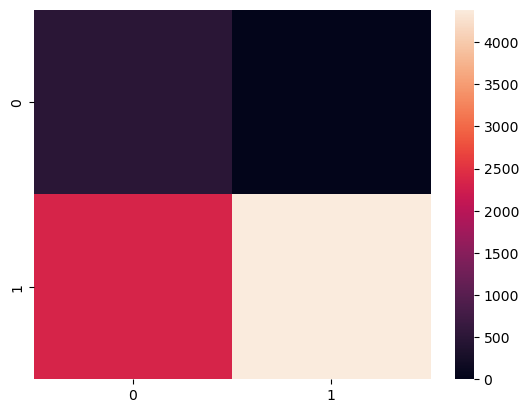

In [112]:
# Matriz de Confusão

sns.heatmap(metrics.confusion_matrix(y_pred, np.argmax(Y_test, axis=-1)))

## Modelo de Emoção

### Carregamento dos Dados Preprocessados

In [2]:
# Carregamento dos dados

emocao_texto = pl.load(open("../dados/preprocessados/emocao_texto.pkl", "rb"))
emocao_label = pl.load(open("../dados/preprocessados/emocao_label.pkl", "rb"))

In [3]:
emocao_texto

array([[ 6447,   291,   154, ...,     0,     0,     0],
       [ 1755,  9991,   206, ...,     0,     0,     0],
       [ 9992,    65,    63, ...,     0,     0,     0],
       ...,
       [   54,    59,    21, ...,     0,     0,     0],
       [   54,    59,    21, ...,     0,     0,     0],
       [36459,  8839,   845, ...,     0,     0,     0]])

In [4]:
emocao_label

array([2, 2, 0, ..., 3, 3, 3], dtype=int64)

In [22]:
# One-Hot Encoding da label

#emocao_label = tf_keras.utils.to_categorical(emocao_label, 5)
#emocao_label

### Desenvolvimento da Arquitetura

In [77]:
class Modelo_de_Emocao():
    
   
    def __init__(self, dim_embedding, num_neuronios, attention, tamanho_vocab, tamanho_frase):
        
        self.dim_embedding = dim_embedding
        self.num_neuronios = num_neuronios
        self.tamanho_vocab = tamanho_vocab
        self.tamanho_frase = tamanho_frase
        self.attention = attention
        
    def constroi_modelo(self):
        
        # Camadas de entrada
        inputs = tf_keras.layers.Input(shape=(self.tamanho_frase, ))
        embedding = tf_keras.layers.Embedding(self.tamanho_vocab, self.dim_embedding, input_length=self.tamanho_frase)(inputs)
        
        # Camadas escondidas
        gru = tf_keras.layers.Bidirectional(tf_keras.layers.GRU(self.num_neuronios, return_sequences=True))(embedding)
        
        # Mecanismo de Atenção
        attention_layer1 = tf_keras.layers.Dense(self.attention, activation='tanh')(gru)
        attention_layer2 = tf_keras.layers.Dense(1)(attention_layer1)
        attention_layer3 = tf_keras.layers.Activation('softmax')(attention_layer2)
        attention_output = tf_keras.layers.Dot(axes=1)([attention_layer3, gru])
        flatten = tf_keras.layers.Flatten()(attention_output)
        flatten = tf_keras.layers.RepeatVector(self.tamanho_frase)(flatten)
        concatenated_attention = tf_keras.layers.Concatenate()([gru, flatten])
        
        # Camada de saída
        dense1 = tf_keras.layers.Dense(2 * self.num_neuronios, activation='relu')(concatenated_attention)
        dense2 = tf_keras.layers.Dense(self.num_neuronios / 2, activation='relu')(dense1)
        flatten2 = tf_keras.layers.Flatten()(dense2)
        dense_output = tf_keras.layers.Dense(5, activation='softmax')(flatten2)
        
        # Modelo
        modelo = tf_keras.models.Model(inputs=inputs, outputs=dense_output)
        
        return modelo

In [78]:
# Sumário do Modelo

modelo = Modelo_de_Emocao(512, 256, 256, 100000, 1000) # Hiperparâmetros de exemplo
modelo = modelo.constroi_modelo()
modelo.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1000, 512)    51200000    ['input_4[0][0]']                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 1000, 512)   1182720     ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 dense_15 (Dense)               (None, 1000, 256)    131328      ['bidirectional_3[0][0]']  

### Train Test Split

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

emocao_texto = scaler.fit_transform(emocao_texto)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(emocao_texto, emocao_label, test_size=.1, random_state=300)

In [7]:
X_train.shape

(23493, 300)

In [8]:
X_test.shape

(2611, 300)

### Treinamento do Modelo: ANN

In [82]:
# PARÂMETROS

tf.random.set_seed(430)

params = {'tamanho_vocab': 38965, 'tamanho_frase': 1000, 'learning_rate': .01,
          'num_neuronios': 256, 'dim_embedding': 512, 'attention': 256}

modelo = Modelo_de_Emocao(params["dim_embedding"], params["num_neuronios"], 
                                params["attention"], params["tamanho_vocab"], params["tamanho_frase"])

modelo = modelo.constroi_modelo()

In [83]:
modelo.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1000, 512)    19950080    ['input_5[0][0]']                
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 1000, 512)   1182720     ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 dense_20 (Dense)               (None, 1000, 256)    131328      ['bidirectional_4[0][0]']  

In [84]:
modelo.compile(loss='categorical_crossentropy', 
               optimizer=tf_keras.optimizers.Adadelta(learning_rate=params["learning_rate"]), metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = tf_keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
model_checkpoint = tf_keras.callbacks.ModelCheckpoint('../modelos/modelo_emocao.h5', monitor='val_accuracy', save_best_only=True)

# Tempo inicial
now = datetime.datetime.now()

# Treinamento do modelo
history = modelo.fit(X_train, Y_train, epochs=2, validation_data=(X_test, Y_test), 
                     batch_size=16, callbacks=[early_stopping, model_checkpoint])
# Tempo final
now2 = datetime.datetime.now()

time = now2 - now
print(f"O tempo que levou para treinar é de {time}")

Epoch 1/2
   2/1592 [..............................] - ETA: 8:57:36 - loss: 22.3143 - accuracy: 0.0938 

### Avaliação do Modelo

In [65]:
modelo = tf_keras.models.load_model("../modelos/modelo_emocao.h5")

In [66]:
pred = modelo.predict(X_test)

89/89 [==============================] - 337s 4s/step


In [67]:
pred = np.argmax(pred, axis=-1)

### Treinamento do Modelo: Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
clf = RandomForestClassifier(n_estimators=300, criterion='entropy', min_samples_split=3)

In [11]:
clf.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=3,
                       n_estimators=300)

In [12]:
pred2 = clf.predict(X_test)

In [13]:
pred2

array([1, 1, 1, ..., 1, 3, 0], dtype=int64)

In [14]:
np.unique(pred2)

array([0, 1, 2, 3], dtype=int64)

In [15]:
print(metrics.classification_report(pred2, Y_test))

              precision    recall  f1-score   support

           0       0.53      0.47      0.50       966
           1       0.65      0.38      0.48      1414
           2       0.07      0.27      0.11       130
           3       0.12      0.48      0.19       101

    accuracy                           0.41      2611
   macro avg       0.34      0.40      0.32      2611
weighted avg       0.56      0.41      0.46      2611



In [16]:
pl.dump(clf, open("../modelos/modelo_emocao.pkl", "wb"))